In [1]:
!wget https://repository.gatech.edu/bitstreams/03f9679f-28ce-4d8b-b195-4b3b1aa4adc9/download -O biomechanics_data.zip

--2025-10-22 06:10:00--  https://repository.gatech.edu/bitstreams/03f9679f-28ce-4d8b-b195-4b3b1aa4adc9/download
Resolving repository.gatech.edu (repository.gatech.edu)... 143.215.137.31
Connecting to repository.gatech.edu (repository.gatech.edu)|143.215.137.31|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://repository.gatech.edu/server/api/core/bitstreams/03f9679f-28ce-4d8b-b195-4b3b1aa4adc9/content [following]
--2025-10-22 06:10:05--  https://repository.gatech.edu/server/api/core/bitstreams/03f9679f-28ce-4d8b-b195-4b3b1aa4adc9/content
Reusing existing connection to repository.gatech.edu:443.
HTTP request sent, awaiting response... 200 200
Length: 13378286332 (12G) [application/octet-stream]
Saving to: ‘biomechanics_data.zip’

biomechanics_data.z 100%[===================>]  12.46G  25.0MB/s    in 5m 29s  

2025-10-22 06:15:34 (38.8 MB/s) - ‘biomechanics_data.zip’ saved [13378286332/13378286332]



In [2]:
import zipfile
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import os

# ---------------------- Paths & Groups ----------------------

ZIP_PATH = "biomechanics_data.zip"  # ZIP file path

GROUPS = {
    "stairs up": ["stairs_1_3_up", "stairs_1_7_up", "stairs_1_9_up", "stairs_1_1_up", "stairs_1_11_up", "stairs_1_5_up"],
    "stairs down": ["stairs_1_2_down", "stairs_1_10_down", "stairs_1_12_down", "stairs_1_6_down", "stairs_1_8_down", "stairs_1_4_down"],
    "incline": ["incline_walk_1_up5", "incline_walk_2_up10"],
    "decline": ["incline_walk_2_down10", "incline_walk_1_down5"],
    "cutting": ["cutting_1_right-slow", "cutting_1_left-slow", "cutting_1_left-fast", "cutting_1_right-fast"],
    "jump": ["jump_1_fb", "jump_2_lateral", "jump_2_180", "jump_3_90-1", "jump_3_90-2", "jump_1_vertical", "jump_1_hop"],
    "run": ["tire_run_1"],
    "obstacle": ["obstacle_walk_1"], 
    "ball": ["ball_toss_1_right", "ball_toss_1_center", "ball_toss_1_left"],
    "normal_walk": ["normal_walk_1_shuffle", "normal_walk_1_2-5", "normal_walk_1_0-6", "normal_walk_1_skip", "normal_walk_1_1-2", "normal_walk_1_1-8", "normal_walk_1_2-0"],
    "poses": ["poses_1"],
    "lift": ["lift_weight_2_0lbs-r-r", "lift_weight_1_25lbs-r-r", "lift_weight_1_25lbs-r-c", "lift_weight_1_25lbs-l-l", "lift_weight_2_0lbs-r-c", "lift_weight_1_25lbs-l-c", "lift_weight_2_0lbs-l-l", "lift_weight_2_0lbs-l-c"],
    "step": ["step_ups_1_right", "step_ups_1_left"],
    "sit": ["sit_to_stand_2_tall-noarm", "sit_to_stand_1_short-noarm", "sit_to_stand_1_short-arm"],
    "curb": ["curb_up_1", "curb_down_1"],
    "walk_backward": ["walk_backward_1_1-0", "walk_backward_1_0-6", "walk_backward_1_0-8"],
    "squats": ["squats_1_25lbs", "squats_1_0lbs"],
    "start_stop": ["start_stop_1"],
    "calisthenics": ["dynamic_walk_1_heel-walk", "dynamic_walk_1_toe-walk", "dynamic_walk_1_high-knees", "dynamic_walk_1_butt-kicks"],
    "push": ["push_1"],
    "tug of war": ["tug_of_war_1"],
    "lunge": ["lunges_2_right", "lunges_2_left", "lunges_1"],
    "side": ["side_shuffle_1"],
    "twister": ["twister_1"],
    "turn": ["turn_and_step_1_left-turn", "turn_and_step_1_right-turn"],
    "meander": ["meander_1"],
    "weighted_walk": ["weighted_walk_1_25lbs"]
}

# ---------------------- Subgroups for selective testing ----------------------
SubGROUPS = {
    "stairs up": ["stairs_1_3_up", "stairs_1_7_up"],
    "stairs down": ["stairs_1_2_down", "stairs_1_10_down"],
    "incline": ["incline_walk_1_up5", "incline_walk_2_up10"],
    "decline": ["incline_walk_2_down10", "incline_walk_1_down5"],
    "cutting": ["cutting_1_right-slow", "cutting_1_left-slow"],
    "jump": ["jump_1_fb", "jump_3_90-1","jump_1_vertical", "jump_1_hop"],
    "run": ["tire_run_1"],
    "obstacle": ["obstacle_walk_1"],
    "ball": ["ball_toss_1_right", "ball_toss_1_center"],
    "normal_walk": ["normal_walk_1_shuffle", "normal_walk_1_2-5", "normal_walk_1_0-6"],
    "poses": ["poses_1"],
    "lift": ["lift_weight_2_0lbs-r-r", "lift_weight_1_25lbs-r-r"],
    "step": ["step_ups_1_right", "step_ups_1_left"],
    "sit": [ "sit_to_stand_1_short-arm"],
    "curb": ["curb_up_1", "curb_down_1"],
    "walk_backward": ["walk_backward_1_1-0", "walk_backward_1_0-6"],
    "squats": ["squats_1_25lbs", "squats_1_0lbs"],
    "start_stop": ["start_stop_1"],
    "calisthenics": ["dynamic_walk_1_heel-walk", "dynamic_walk_1_toe-walk"],
    "push": ["push_1"],
    "tug of war": ["tug_of_war_1"],
    "lunge": ["lunges_2_right", "lunges_1"],
    "side": ["side_shuffle_1"],
    "twister": ["twister_1"],
    "turn": ["turn_and_step_1_left-turn", "turn_and_step_1_right-turn"],
    "meander": ["meander_1"],
    "weighted_walk": ["weighted_walk_1_25lbs"]
}

# ---------------------- Column definitions ----------------------
IMU_COLUMNS = [
    'LShank_ACCX', 'LShank_ACCY', 'LShank_ACCZ', 'LShank_GYROX', 'LShank_GYROY', 'LShank_GYROZ',
    'LAThigh_ACCX', 'LAThigh_ACCY', 'LAThigh_ACCZ', 'LAThigh_GYROX', 'LAThigh_GYROY', 'LAThigh_GYROZ',
    'LPThigh_ACCX', 'LPThigh_ACCY', 'LPThigh_ACCZ', 'LPThigh_GYROX', 'LPThigh_GYROY', 'LPThigh_GYROZ',
    'LPelvis_ACCX', 'LPelvis_ACCY', 'LPelvis_ACCZ', 'LPelvis_GYROX', 'LPelvis_GYROY', 'LPelvis_GYROZ'
]
INSOLE_COLUMNS = ['LCOP_AP', 'LCOP_ML', 'LVerticalF', 'LShearF_AP', 'LShearF_ML']
EMG_COLUMNS = ['LVL', 'LRF', 'LBF', 'LMGAS', 'LGMED', 'LGMAX']
MOMENT_COLUMNS = ['hip_flexion_l_moment', 'knee_angle_l_moment']

# ---------------------- Signal processing functions ----------------------
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return b, a

def process_emg_signal(signal, original_fs, target_times):
    signal = signal - np.mean(signal)
    b, a = butter_bandpass(30, 300, fs=original_fs, order=4)
    signal = filtfilt(b, a, signal)
    signal = np.abs(signal)
    b, a = butter_lowpass(6, fs=original_fs, order=4)
    signal = filtfilt(b, a, signal)
    signal *= 10000
    original_times = np.linspace(0, len(signal)/original_fs, len(signal))
    signal_sync = np.interp(target_times, original_times, signal)
    return signal_sync

# ---------------------- Data collection function ----------------------
def collect_subject_data(subject_name, original_emg_fs=2000, joint=None):
    all_data = []

    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_files = zip_ref.namelist()
        for group_name, task_list in GROUPS.items():
            for task in task_list:
                task_folder = f"{subject_name}/{task}/"
                if not any(task_folder in f for f in zip_files):
                    continue

                files_dict = {}
                required_suffixes = ["angle.csv", "velocity.csv", "imu_real.csv", "insole_sim.csv", "emg.csv", "moment_filt.csv"]
                for suffix in required_suffixes:
                    file_path = f"{subject_name}/{task}/{subject_name}_{task}_{suffix}"
                    if file_path not in zip_files:
                        raise FileNotFoundError(f"❌ File {suffix} for task '{task}' in group '{group_name}' not found!")
                    files_dict[suffix] = file_path

                with zip_ref.open(files_dict["angle.csv"]) as file:
                    df_angle = pd.read_csv(file, usecols=['time', 'hip_flexion_l', 'knee_angle_l'])
                with zip_ref.open(files_dict["velocity.csv"]) as file:
                    df_vel = pd.read_csv(file, usecols=['time', 'hip_flexion_velocity_l', 'knee_velocity_l'])
                with zip_ref.open(files_dict["imu_real.csv"]) as file:
                    df_imu = pd.read_csv(file, usecols=['time'] + IMU_COLUMNS)
                with zip_ref.open(files_dict["insole_sim.csv"]) as file:
                    df_insole = pd.read_csv(file, usecols=['time'] + INSOLE_COLUMNS)
                with zip_ref.open(files_dict["emg.csv"]) as file:
                    df_emg_raw = pd.read_csv(file, usecols=['time'] + EMG_COLUMNS)
                with zip_ref.open(files_dict["moment_filt.csv"]) as file:
                    df_moment = pd.read_csv(file)

                target_times = df_angle['time'].values
                df_emg = pd.DataFrame({'time': target_times})
                for col in EMG_COLUMNS:
                    df_emg[col] = process_emg_signal(df_emg_raw[col].values, original_emg_fs, target_times)

                df = pd.merge(df_angle, df_vel, on='time', how='left')
                df = pd.merge(df, df_imu, on='time', how='left')
                df = pd.merge(df, df_insole, on='time', how='left')
                df = pd.merge(df, df_emg, on='time', how='left')

                for col in MOMENT_COLUMNS:
                    df[col] = np.interp(df['time'].values, df_moment['time'].values, df_moment[col].values)

                df['subject'] = subject_name
                df['group'] = group_name
                df['task'] = task
                df['file_path'] = files_dict["angle.csv"]

                # ✅ NEW: Assign subgroup
                df['subgroup'] = None
                for sg_name, sg_tasks in SubGROUPS.items():
                    if task in sg_tasks and group_name == sg_name:
                        df['subgroup'] = sg_name
                        break

                all_data.append(df)

    if all_data:
        full_df = pd.concat(all_data, ignore_index=True)

        # ---------------------- NaN report ----------------------
        columns_to_check = ['LCOP_AP', 'LCOP_ML', 'LVerticalF', 'LShearF_AP', 'LShearF_ML',
                            'hip_flexion_l_moment', 'knee_angle_l_moment']
        total_rows_before = len(full_df)
        total_nans = full_df[columns_to_check].isna().sum().sum()
        total_possible = total_rows_before * len(columns_to_check)
        nan_percentage = (total_nans / total_possible) * 100

        print("\n🌟🌟🌟 [NaN REPORT] 🌟🌟🌟")
        print(f"📊 Total rows before NaN removal: {total_rows_before}")
        print(f"💀 Total NaNs in important columns: {total_nans}")
        print(f"📈 NaN percentage: {nan_percentage:.2f}%")
        print("--------------------------------------------------")

        all_nan_rows = full_df[columns_to_check].isna().all(axis=1)
        full_df = full_df[~all_nan_rows]

        total_rows_after = len(full_df)
        print(f"✅ Total rows after removing NaN rows: {total_rows_after}")
        print(f"🔹 Removed rows count: {total_rows_before - total_rows_after}")
        print("==================================================\n")

        # ---------------------- Mirror data ----------------------
        def _left_to_base_columns_map(columns):
            mapping = {}
            for col in columns:
                if col in ['time', 'subject', 'group', 'task', 'file_path', 'subgroup']:
                    mapping[col] = col
                elif col.endswith('_l_moment'):
                    mapping[col] = col.replace('_l_moment', '_moment')
                elif col.endswith('_l'):
                    mapping[col] = col[:-2]
                elif col.startswith('L') and len(col) > 1:
                    mapping[col] = col[1:]
                else:
                    mapping[col] = col
            return mapping

        col_map = _left_to_base_columns_map(full_df.columns)
        base_df = full_df.rename(columns=col_map).copy()
        mirrored_df = base_df.copy()

        flip_accy = [c for c in base_df.columns if 'ACCY' in c]
        flip_gyro = [c for c in base_df.columns if ('GYROX' in c) or ('GYROZ' in c)]
        flip_cop_ml = [c for c in base_df.columns if 'COP_ML' in c]
        flip_shear_ml = [c for c in base_df.columns if 'ShearF_ML' in c]
        flip_cols = list(set(flip_accy + flip_gyro + flip_cop_ml + flip_shear_ml))
        numeric_cols = [c for c in flip_cols if np.issubdtype(mirrored_df[c].dtype, np.number)]
        mirrored_df[numeric_cols] = mirrored_df[numeric_cols] * -1

        base_df['side'] = 'L'
        mirrored_df['side'] = 'R'
        mirrored_df['file_path'] = mirrored_df['file_path'].astype(str) + "_mirrored"
        combined_df = pd.concat([base_df, mirrored_df], ignore_index=True)

        print(f"\n🪞 [Mirror REPORT] Total rows after mirroring: {len(combined_df)}")
        print("==================================================")

        # ---------------------- Joint filter ----------------------
        if joint is not None:
            joint = joint.lower()
            if joint == 'knee':
                joint_cols = [
                    'time', 'knee_angle', 'knee_velocity',
                    'Shank_ACCX', 'Shank_ACCY', 'Shank_ACCZ',
                    'Shank_GYROX', 'Shank_GYROY', 'Shank_GYROZ',
                    'AThigh_ACCX', 'AThigh_ACCY', 'AThigh_ACCZ',
                    'AThigh_GYROX', 'AThigh_GYROY', 'AThigh_GYROZ',
                    'COP_AP', 'COP_ML', 'VerticalF', 'ShearF_AP', 'ShearF_ML',
                    'VL', 'RF', 'BF', 'MGAS',
                    'knee_angle_moment', 'subject', 'group', 'task', 'file_path', 'side', 'subgroup'
                ]
            elif joint == 'hip':
                joint_cols = [
                    'time', 'hip_flexion', 'hip_flexion_velocity',
                    'PThigh_ACCX', 'PThigh_ACCY', 'PThigh_ACCZ',
                    'PThigh_GYROX', 'PThigh_GYROY', 'PThigh_GYROZ',
                    'Pelvis_ACCX', 'Pelvis_ACCY', 'Pelvis_ACCZ',
                    'Pelvis_GYROX', 'Pelvis_GYROY', 'Pelvis_GYROZ',
                    'COP_AP', 'COP_ML', 'VerticalF', 'ShearF_AP', 'ShearF_ML',
                    'RF', 'BF', 'GMED', 'GMAX',
                    'hip_flexion_moment', 'subject', 'group', 'task', 'file_path', 'side', 'subgroup'
                ]
            else:
                raise ValueError("joint must be 'Hip' or 'Knee'")
            joint_df = combined_df[joint_cols].copy()
            print(f"🦵 [Joint REPORT] Joint '{joint}' dataset extracted: {len(joint_df)} rows, {len(joint_df.columns)} columns")
            print("==================================================")
        else:
            joint_df = None

        print(f"\n📊 [FINAL REPORT] Full dataset total rows: {len(combined_df)}")
        print(f"📌 Joint dataset total rows: {len(joint_df) if joint_df is not None else 0}")
        print("==================================================\n")

        return combined_df, joint_df
    else:
        print(f"⚠️ No data found for subject {subject_name}.")
        return None, None

# ---------------------- Wrapper code for all subjects ----------------------
def process_all_subjects(joint_input):
    subjects = ["AB01"]
    saved_dfs = {}

    for subject in subjects:
        print(f"\n==================================================")
        print(f"🚀 Processing subject: {subject}, joint: {joint_input}")
        print("==================================================\n")

        try:
            _, joint_df = collect_subject_data(subject_name=subject, joint=joint_input)

            if joint_df is not None:
                df_name = f"{subject}_{joint_input}_df"
                saved_dfs[df_name] = joint_df
                file_name = f"{df_name}.pkl"
                joint_df.to_pickle(file_name)
                print(f"✅ DataFrame '{df_name}' saved as '{file_name}'")
            else:
                print(f"⚠️ No joint DataFrame generated for subject {subject}.")
        except Exception as e:
            print(f"❌ Error processing subject {subject}: {str(e)}")

    print("\n==================================================")
    print("📊 Final Report: Generated DataFrames")
    if saved_dfs:
        for df_name in saved_dfs.keys():
            print(f"🗂 {df_name} (Rows: {len(saved_dfs[df_name])}, Columns: {len(saved_dfs[df_name].columns)})")
    else:
        print("⚠️ No DataFrames generated.")
    print("==================================================\n")

    return saved_dfs

# ---------------------- Main execution ----------------------
if __name__ == "__main__":
    joint_input = input("Enter joint to extract for all subjects (Hip or Knee): ").strip()
    all_joint_dfs = process_all_subjects(joint_input)



Enter joint to extract for all subjects (Hip or Knee):  hip



🚀 Processing subject: AB01, joint: hip


🌟🌟🌟 [NaN REPORT] 🌟🌟🌟
📊 Total rows before NaN removal: 385947
💀 Total NaNs in important columns: 440489
📈 NaN percentage: 16.30%
--------------------------------------------------
✅ Total rows after removing NaN rows: 323020
🔹 Removed rows count: 62927


🪞 [Mirror REPORT] Total rows after mirroring: 646040
🦵 [Joint REPORT] Joint 'hip' dataset extracted: 646040 rows, 31 columns

📊 [FINAL REPORT] Full dataset total rows: 646040
📌 Joint dataset total rows: 646040

✅ DataFrame 'AB01_hip_df' saved as 'AB01_hip_df.pkl'

📊 Final Report: Generated DataFrames
🗂 AB01_hip_df (Rows: 646040, Columns: 31)



In [3]:
# ---------------------- Imports ----------------------
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dropout, ReLU, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.mixed_precision import Policy, set_global_policy
from tensorflow.keras.mixed_precision import LossScaleOptimizer
from google.colab import drive
import shutil
import glob

# ---------------------- Setup ----------------------
policy = Policy('mixed_float16')
set_global_policy(policy)

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except:
        pass

tf.config.optimizer.set_jit(True)

# ---------------------- Google Drive ----------------------
# Uncomment if using Google Colab
# drive.mount('/content/drive')
# backup_dir = "/content/drive/MyDrive/model_backups_AB05_knee"

# For Kaggle or local execution, use a local backup directory
backup_dir = "/kaggle/working/model_backups_AB01_hip"

os.makedirs(backup_dir, exist_ok=True)

# ---------------------- Load Data ----------------------
file_path = "/kaggle/working/AB01_hip_df.pkl"
with open(file_path, "rb") as f:
    df = pickle.load(f)

# ---------------------- Feature Sets ----------------------
features_sets = {
# ---------------------- Feature Sets ----------------------

    "kinematic": [
        'hip_flexion', 'hip_flexion_velocity', # Hip Kinematics
        'PThigh_ACCX', 'PThigh_ACCY', 'PThigh_ACCZ', # PThigh IMU
        'PThigh_GYROX', 'PThigh_GYROY', 'PThigh_GYROZ',
        'Pelvis_ACCX', 'Pelvis_ACCY', 'Pelvis_ACCZ', # Pelvis IMU
        'Pelvis_GYROX', 'Pelvis_GYROY', 'Pelvis_GYROZ'
    ],
    "kinematic_insole": [
        'hip_flexion', 'hip_flexion_velocity',
        'PThigh_ACCX', 'PThigh_ACCY', 'PThigh_ACCZ',
        'PThigh_GYROX', 'PThigh_GYROY', 'PThigh_GYROZ',
        'Pelvis_ACCX', 'Pelvis_ACCY', 'Pelvis_ACCZ',
        'Pelvis_GYROX', 'Pelvis_GYROY', 'Pelvis_GYROZ',
        'COP_AP', 'COP_ML', 'VerticalF', 'ShearF_AP', 'ShearF_ML' # Insoles
    ],
    "kinematic_emg": [
        'hip_flexion', 'hip_flexion_velocity',
        'PThigh_ACCX', 'PThigh_ACCY', 'PThigh_ACCZ',
        'PThigh_GYROX', 'PThigh_GYROY', 'PThigh_GYROZ',
        'Pelvis_ACCX', 'Pelvis_ACCY', 'Pelvis_ACCZ',
        'Pelvis_GYROX', 'Pelvis_GYROY', 'Pelvis_GYROZ',
        'RF', 'BF', 'GMED', 'GMAX' # Hip EMGs
    ],
    "all": [
        'hip_flexion', 'hip_flexion_velocity',
        'PThigh_ACCX', 'PThigh_ACCY', 'PThigh_ACCZ',
        'PThigh_GYROX', 'PThigh_GYROY', 'PThigh_GYROZ',
        'Pelvis_ACCX', 'Pelvis_ACCY', 'Pelvis_ACCZ',
        'Pelvis_GYROX', 'Pelvis_GYROY', 'Pelvis_GYROZ',
        'COP_AP', 'COP_ML', 'VerticalF', 'ShearF_AP', 'ShearF_ML',
        'RF', 'BF', 'GMED', 'GMAX'
    ]
}
# Change the label column to the hip moment
label_col = "hip_flexion_moment" 
selected_tasks = ["kinematic", "kinematic_emg", "kinematic_insole", "all"]

# ---------------------- Subgroups ----------------------
SUBGROUPS = {
    "stairs up": ["stairs_1_11_up", "stairs_1_5_up"],
    "stairs down": ["stairs_1_2_down", "stairs_1_10_down"],
    "incline": ["incline_walk_1_up5", "incline_walk_2_up10"],
    "decline": ["incline_walk_2_down10", "incline_walk_1_down5"],
    "cutting": ["cutting_1_right-slow", "cutting_1_left-slow"],
    "jump": ["jump_1_fb", "jump_3_90-1","jump_1_vertical", "jump_1_hop"],

    "obstacle": ["obstacle_walk_1"],
    "ball": ["ball_toss_1_right", "ball_toss_1_center"],
    "normal_walk": ["normal_walk_1_shuffle", "normal_walk_1_2-5", "normal_walk_1_0-6"],
    "poses": ["poses_1"],
    "lift": ["lift_weight_2_0lbs-l-l", "lift_weight_2_0lbs-l-c"],
    "step": ["step_ups_1_left"],
    "sit": ["sit_to_stand_1_short-arm"],
    "curb": ["curb_up_1", "curb_down_1"],
    "walk_backward": ["walk_backward_1_0-6"],
    "squats": ["squats_1_25lbs", "squats_1_0lbs"],
    "start_stop": ["start_stop_1"],
    "calisthenics": ["dynamic_walk_1_toe-walk", "dynamic_walk_1_butt-kicks"],
    "push": ["push_1"],
    "tug of war": ["tug_of_war_1"],
    "lunge": ["lunges_2_right", "lunges_2_left"],

    "twister": ["twister_1"],
    "turn": ["turn_and_step_1_left-turn", "turn_and_step_1_right-turn"],

    "weighted_walk": ["weighted_walk_1_25lbs"]
}

# ---------------------- Normalization ----------------------
def normalize_data(X):
    mean = np.mean(X, axis=0, keepdims=True)
    std = np.std(X, axis=0, keepdims=True) + 1e-8
    return (X - mean) / std, mean, std

def denormalize_data(X, mean, std):
    return X * std + mean

# ---------------------- WeightNormalizedConv1D ----------------------
class WeightNormalizedConv1D(Conv1D):
    def build(self, input_shape):
        super().build(input_shape)
        self.g = self.add_weight(name='g', shape=(self.filters,), initializer='ones', trainable=True, dtype=self.dtype)

    def call(self, inputs):
        w_norm = tf.math.l2_normalize(self.kernel, axis=[0,1])
        g_reshaped = tf.reshape(self.g, (1,1,-1))
        w_normalized = w_norm * g_reshaped
        padding = self.padding
        if padding == 'causal':
            k = self.kernel_size[0] if isinstance(self.kernel_size, (list, tuple)) else self.kernel_size
            d = self.dilation_rate[0] if isinstance(self.dilation_rate, (list, tuple)) else self.dilation_rate
            pad_len = (k-1)*d
            inputs = tf.pad(inputs, [[0,0],[pad_len,0],[0,0]])
            conv_padding = 'VALID'
        else:
            conv_padding = 'SAME' if padding=='same' else 'VALID'
        strides = (self.strides[0],) if isinstance(self.strides,(list,tuple)) else (self.strides,)
        dilations = (self.dilation_rate[0],) if isinstance(self.dilation_rate,(list,tuple)) else (self.dilation_rate,)
        outputs = tf.nn.convolution(inputs, w_normalized, padding=conv_padding, strides=strides, dilations=dilations)
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.bias)
        return outputs

# ---------------------- TCN ----------------------
def temporal_block(x, n_filters, kernel_size, dropout, dilation_rate):
    prev = x
    conv1 = WeightNormalizedConv1D(n_filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    conv1 = ReLU()(conv1)
    conv1 = Dropout(dropout)(conv1)
    conv2 = WeightNormalizedConv1D(n_filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(conv1)
    conv2 = ReLU()(conv2)
    conv2 = Dropout(dropout)(conv2)
    if prev.shape[-1] != conv2.shape[-1]:
        prev = WeightNormalizedConv1D(conv2.shape[-1], 1)(prev)
    out = Add()([prev, conv2])
    return out

def build_tcn(input_shape, n_filters=50, kernel_size=4, depth=5, dropout=0.1):
    inputs = Input(shape=input_shape)
    x = inputs
    for i in range(depth):
        x = temporal_block(x, n_filters, kernel_size, dropout, dilation_rate=2**i)
    outputs = WeightNormalizedConv1D(1, 1, dtype='float32')(x)
    return Model(inputs, outputs)

# ---------------------- Sequence Helper ----------------------
def create_sequence_data(X, y, seq_len=186, stride=None):
    if stride is None:
        stride = seq_len // 2
    X_seq, y_seq = [], []
    for start in range(0, len(X) - seq_len + 1, stride):
        end = start + seq_len
        X_seq.append(X[start:end])
        y_seq.append(y[start:end])
    if len(X_seq) == 0:
        return np.zeros((0, seq_len, X.shape[1]), dtype=X.dtype), np.zeros((0, seq_len, y.shape[1]), dtype=y.dtype)
    return np.stack(X_seq), np.stack(y_seq)

# ---------------------- Train & Evaluate ----------------------
def train_and_evaluate_gpu(df, features_sets, label_col, selected_tasks, SUBGROUPS, subj="AB01", save_dir="/kaggle/working/"):
    os.makedirs(save_dir, exist_ok=True)
    results_file = os.path.join(save_dir, f"{subj}_results.pkl")
    all_results = {}

    # Load previous results if exist
    if os.path.exists(results_file):
        with open(results_file, "rb") as f:
            all_results = pickle.load(f)

    # Calculate starting run_counter from existing results
    run_counter = 0
    for feat in all_results:
        run_counter += len(all_results[feat])

    print("📤 Backing up existing models...")
    existing_models = glob.glob(os.path.join(save_dir, "*.keras"))
    for model_path in existing_models:
        backup_path = os.path.join(backup_dir, os.path.basename(model_path))
        shutil.copy(model_path, backup_path)
        print(f"📤 Backed up: {backup_path}")

    # ---------------------- Normalize Data ----------------------
    norm_params = {}
    for feat_name in selected_tasks:
        feat_cols = features_sets[feat_name]
        X = df[feat_cols].values.astype(np.float32)
        y = df[[label_col]].values.astype(np.float32)
        X_norm, X_mean, X_std = normalize_data(X)
        y_norm, y_mean, y_std = normalize_data(y)
        norm_params[feat_name] = {"X_mean": X_mean, "X_std": X_std, "y_mean": y_mean, "y_std": y_std}
        df[feat_name+'_norm'] = list(X_norm)
        df[feat_name+'_label'] = list(y_norm)

    for feat_idx, feat_name in enumerate(selected_tasks, 1):
        print(f"\n=== [{feat_idx}/{len(selected_tasks)}] Feature Set: {feat_name} ===")
        if feat_name not in all_results:
            all_results[feat_name] = {}
        subgroup_items = list(SUBGROUPS.items())
        valid_subgroups = [(name, files) for name, files in subgroup_items if df['task'].isin(files).any()]

        for subgroup_idx, (subgroup_name, files) in enumerate(valid_subgroups, 1):
            print(f"--- [{subgroup_idx}/{len(valid_subgroups)}] Leave-out Subgroup: {subgroup_name} ---")
            model_path = os.path.join(save_dir, f"{subj}_{feat_name}_leaveout_{subgroup_name}.keras")
            if os.path.exists(model_path):
                print("Model exists, skipping...")
                continue

            mask_test = df['task'].isin(files)
            mask_train = ~mask_test
            X_train = np.stack(df.loc[mask_train, feat_name+'_norm'].values)
            y_train = np.stack(df.loc[mask_train, feat_name+'_label'].values)
            X_test = np.stack(df.loc[mask_test, feat_name+'_norm'].values)
            y_test = np.stack(df.loc[mask_test, feat_name+'_label'].values)

            X_train_seq, y_train_seq = create_sequence_data(X_train, y_train, seq_len=186, stride=186//2)
            X_test_seq, y_test_seq = create_sequence_data(X_test, y_test, seq_len=186, stride=186//2)
            if X_train_seq.shape[0] == 0 or X_test_seq.shape[0] == 0:
                print(f"⚠️ Not enough data for subgroup '{subgroup_name}'. Skipping.")
                continue

            train_dataset = tf.data.Dataset.from_tensor_slices((X_train_seq, y_train_seq)) \
                                           .shuffle(len(X_train_seq)).batch(128).prefetch(tf.data.AUTOTUNE)
            test_dataset = tf.data.Dataset.from_tensor_slices((X_test_seq, y_test_seq)) \
                                          .batch(128).prefetch(tf.data.AUTOTUNE)

            model = build_tcn(input_shape=(186, X_train.shape[1]))
            optimizer = LossScaleOptimizer(Adam(1e-4))
            model.compile(optimizer=optimizer, loss="mse", jit_compile=True)
            es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

            print("🚀 Training model...")
            model.fit(train_dataset, epochs=15, callbacks=[es], verbose=2)
            model.save(model_path)
            print(f"💾 Saved model: {model_path}")

            y_pred = model.predict(test_dataset, verbose=0)
            y_true = y_test_seq
            if y_pred.shape != y_true.shape:
                y_pred = y_pred.reshape(y_true.shape)

            # Denormalize
            y_mean = norm_params[feat_name]["y_mean"]
            y_std = norm_params[feat_name]["y_std"]
            y_pred = denormalize_data(y_pred, y_mean, y_std)
            y_true = denormalize_data(y_true, y_mean, y_std)

            mse = np.mean((y_true - y_pred)**2)
            rmse = np.sqrt(mse)
            ss_res = np.sum((y_true - y_pred)**2)
            ss_tot = np.sum((y_true - np.mean(y_true))**2)
            r2 = 1 - ss_res / ss_tot if ss_tot>0 else np.nan
            mae_peak = np.mean(np.abs(y_true.max(axis=1)-y_pred.max(axis=1)))

            all_results[feat_name][subgroup_name] = {"rmse": rmse, "r2": r2, "mae_peak": mae_peak}

            print(f"📊 Subgroup {subgroup_name} -> RMSE={rmse:.3f}, R2={r2:.3f}, MAE_peak={mae_peak:.3f}")

            # Increment run counter
            run_counter += 1

            # Save results after each subgroup
            with open(results_file, "wb") as f:
                pickle.dump(all_results, f)

            # Backup every 5 runs
            if run_counter % 5 == 0:
                backup_run_dir = os.path.join(backup_dir, f"backup_run_{run_counter}")
                os.makedirs(backup_run_dir, exist_ok=True)
                # Backup models
                for m in glob.glob(os.path.join(save_dir, "*.keras")):
                    shutil.copy(m, backup_run_dir)
                # Backup results file
                shutil.copy(results_file, backup_run_dir)
                print(f"📦 Backup created at {backup_run_dir}")

            # Free RAM
            del model, train_dataset, test_dataset, X_train, X_test, y_train, y_test, X_train_seq, y_train_seq, X_test_seq, y_test_seq, y_pred
            for _ in range(3):
                gc.collect()
            K.clear_session()

    return all_results

# ---------------------- Run ----------------------
results = train_and_evaluate_gpu(df, features_sets, label_col, selected_tasks, SUBGROUPS, subj="AB01")

2025-10-22 06:17:29.962557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761113850.199574      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761113850.267687      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


📤 Backing up existing models...

=== [1/4] Feature Set: kinematic ===
--- [1/21] Leave-out Subgroup: stairs up ---


I0000 00:00:1761113866.497586      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761113866.498190      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


🚀 Training model...
Epoch 1/15


I0000 00:00:1761113873.114235     102 service.cc:148] XLA service 0x79be6400ec00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761113873.114854     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761113873.114874     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761113873.145245     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761113873.245001     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 - 33s - 598ms/step - loss: 5.4191
Epoch 2/15
55/55 - 1s - 15ms/step - loss: 1.3686
Epoch 3/15
55/55 - 1s - 13ms/step - loss: 1.0319
Epoch 4/15
55/55 - 1s - 13ms/step - loss: 0.8673
Epoch 5/15
55/55 - 1s - 13ms/step - loss: 0.7625
Epoch 6/15
55/55 - 1s - 13ms/step - loss: 0.6928
Epoch 7/15
55/55 - 1s - 13ms/step - loss: 0.6353
Epoch 8/15
55/55 - 1s - 13ms/step - loss: 0.5918
Epoch 9/15
55/55 - 1s - 13ms/step - loss: 0.5545
Epoch 10/15
55/55 - 1s - 13ms/step - loss: 0.5241
Epoch 11/15
55/55 - 1s - 13ms/step - loss: 0.4983
Epoch 12/15
55/55 - 1s - 13ms/step - loss: 0.4753
Epoch 13/15
55/55 - 1s - 13ms/step - loss: 0.4562
Epoch 14/15
55/55 - 1s - 12ms/step - loss: 0.4384
Epoch 15/15
55/55 - 1s - 12ms/step - loss: 0.4234
💾 Saved model: /kaggle/working/AB01_kinematic_leaveout_stairs up.keras
📊 Subgroup stairs up -> RMSE=0.215, R2=0.541, MAE_peak=0.236
--- [2/21] Leave-out Subgroup: stairs down ---
🚀 Training model...
Epoch 1/15
55/55 - 29s - 531ms/step - loss: 5.2675
Epoch 2/15
55/55 -

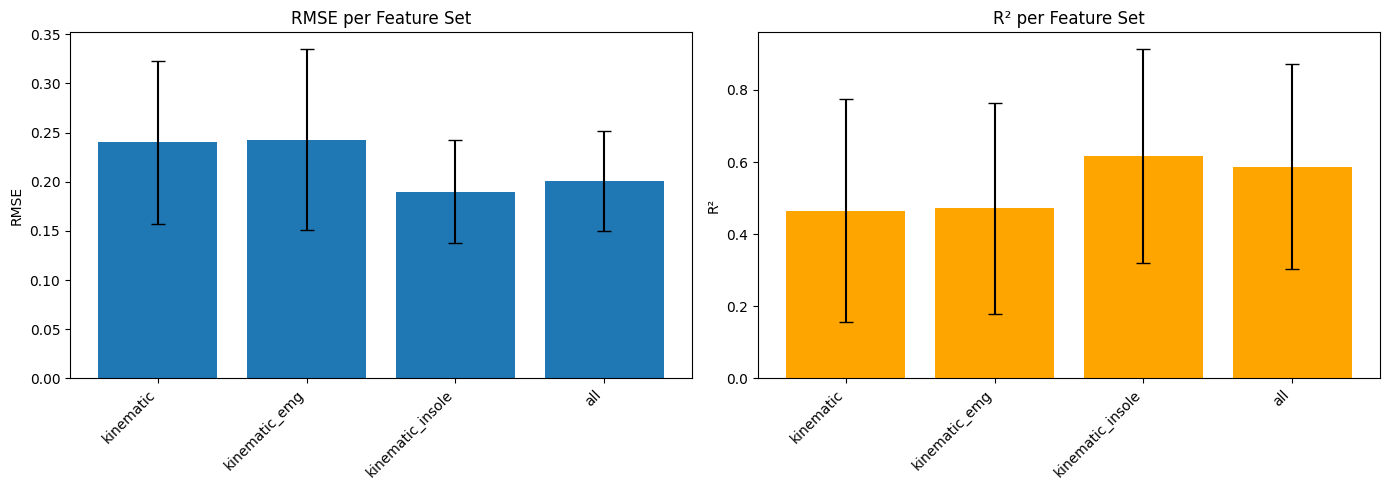

✅ Plots saved in /content/model


In [4]:
# ---------------------- Plots & Save ----------------------
import matplotlib.pyplot as plt

def plot_results(all_results, save_dir="/content/model", subj="AB01"):
    task_names, rmse_means, rmse_stds, r2_means, r2_stds = [], [], [], [], []

    for task_name, task_dict in all_results.items():
        task_rmse = [v["rmse"] for v in task_dict.values() if not np.isnan(v["rmse"])]
        task_r2 = [v["r2"] for v in task_dict.values() if not np.isnan(v["r2"])]

        if len(task_rmse) == 0 or len(task_r2) == 0:
            continue  # Skip if no data

        task_names.append(task_name)
        rmse_means.append(np.mean(task_rmse))
        rmse_stds.append(np.std(task_rmse))
        r2_means.append(np.mean(task_r2))
        r2_stds.append(np.std(task_r2))

    if len(task_names) == 0:
        print("⚠️ No results available for plotting.")
        return

    x = np.arange(len(task_names))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

    ax1.bar(x, rmse_means, yerr=rmse_stds, capsize=5)
    ax1.set_xticks(x)
    ax1.set_xticklabels(task_names, rotation=45, ha="right")
    ax1.set_ylabel("RMSE")
    ax1.set_title("RMSE per Feature Set")

    ax2.bar(x, r2_means, yerr=r2_stds, capsize=5, color="orange")
    ax2.set_xticks(x)
    ax2.set_xticklabels(task_names, rotation=45, ha="right")
    ax2.set_ylabel("R²")
    ax2.set_title("R² per Feature Set")

    plt.tight_layout()

    # Show plots
    plt.show()

    # Save plots
    os.makedirs(save_dir, exist_ok=True)
    fig.savefig(os.path.join(save_dir, f"{subj}_metrics.png"), dpi=300, bbox_inches="tight")
    fig.savefig(os.path.join(save_dir, f"{subj}_metrics.svg"), bbox_inches="tight")
    print(f"✅ Plots saved in {save_dir}")

# ---------------------- Call Plot ----------------------
plot_results(results, save_dir="/content/model", subj="AB01")
